### Implementação do NSGA-II

Foi utilizado como base para implementação esse repositório do github: https://github.com/baopng/NSGA-II.

Inicialmente é definida as classes que irão ser úteis para a execução do problema.

In [31]:
import random

class Individual:
    def __init__(self):
        self.rank = None
        self.crowding_distance = None
        self.domination_count = None
        self.dominated_solutions = None
        self.dec_variables = None
        self.objectives = None
        
    def __eq__(self, other):
        if isinstance(self, other.__class__):
            return self.dec_variables == other.dec_variables
        return False
        
    def dominance(self, otherSolution):
        tag = False
        for i in range(len(self.objectives)):
            if self.objectives[i] > otherSolution.objectives[i]:
                return False
            if self.objectives[i] < otherSolution.objectives[i]:
                tag = True
        return tag

In [2]:
class Population:
    def __init__(self):
        self.population = []
        self.fronts = []

    def __iter__(self):
        return self.population.__iter__()
        
    def __len__(self):
        return len(self.population)

    def extend(self, new_individuals):
        self.population.extend(new_individuals)

    def append(self, new_individual):
        self.population.append(new_individual)

In [8]:
class Problem:
    def __init__(self, objectives, num_of_variables, variables_range, same_range=True):
        self.num_of_objectives = len(objectives)
        self.num_of_variables = num_of_variables
        self.objectives = objectives
        self.variables_range = []
        if same_range:
            for _ in range(num_of_variables):
                self.variables_range.append(variables_range[0])
        else:
            self.variables_range = variables_range

    def generate_individual(self):
        individual = Individual()
        individual.dec_variables = [random.uniform(*x) for x in self.variables_range]
        return individual

    def calculate_objectives(self, individual):
        individual.objectives = [f(individual.dec_variables) for f in self.objectives]

É definida uma Classe Utils, que traz alguns métodos de utilidade para a execução do problema, como por exemplo mutação, cruzamento, ordenação.

In [15]:
class Utils:
    def __init__(self, problem, num_of_individuals,
                 num_of_tour_particips, tournament_prob, crossover_param, mutation_param):

        self.problem = problem
        self.num_of_individuals = num_of_individuals
        self.num_of_tour_particips = num_of_tour_particips
        self.tournament_prob = tournament_prob
        self.crossover_param = crossover_param
        self.mutation_param = mutation_param

    def create_initial_population(self):
        population = Population()
        for _ in range(self.num_of_individuals):
            individual = self.problem.generate_individual()
            self.problem.calculate_objectives(individual)
            population.append(individual)
        return population

    def fast_nondominated_sort(self, population):
        population.fronts = [[]]
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = []
            for q in population:
                if p.dominance(q):
                    p.dominated_solutions.append(q)
                elif q.dominance(p):
                    p.domination_count += 1
            if p.domination_count == 0:
                p.rank = 0
                population.fronts[0].append(p)
        i = 0
        while population.fronts[i] != []:
            Q = []
            for p in population.fronts[i]:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = i+1
                        Q.append(q)
            i += 1
            population.fronts.append(Q)
    
    def calculate_crowding_distance(self, front):
        if len(front) > 0:
            solutions_num = len(front)
            for individual in front:
                individual.crowding_distance = 0

            for m in range(len(front[0].objectives)):
                front.sort(key=lambda individual: individual.objectives[m])
                front[0].crowding_distance = 10 ** 9
                front[solutions_num - 1].crowding_distance = 10 ** 9
                m_values = [individual.objectives[m] for individual in front]
                scale = max(m_values) - min(m_values)
                if scale == 0: scale = 1
                for i in range(1, solutions_num - 1):
                    front[i].crowding_distance += (front[i + 1].objectives[m] - front[i - 1].objectives[m]) / scale

    def crowding_operator(self, individual, other_individual):
        if (individual.rank < other_individual.rank) or \
                ((individual.rank == other_individual.rank) and (
                        individual.crowding_distance > other_individual.crowding_distance)):
            return 1
        else:
            return -1

    def create_children(self, population):
        children = []
        while len(children) < len(population):
            parent1 = self.__tournament(population)
            parent2 = parent1
            while parent1 == parent2:
                parent2 = self.__tournament(population)
            child1, child2 = self.__crossover(parent1, parent2)
            self.__mutate(child1)
            self.__mutate(child2)
            self.problem.calculate_objectives(child1)
            self.problem.calculate_objectives(child2)
            children.append(child1)
            children.append(child2)

        return children

    def __crossover(self, individual1, individual2):
        child1 = self.problem.generate_individual()
        child2 = self.problem.generate_individual()
        num_of_dec_variables = len(child1.dec_variables)
        genes_indexes = range(num_of_dec_variables)
        for i in genes_indexes:
            beta = self.__get_beta()
            x1 = (individual1.dec_variables[i] + individual2.dec_variables[i]) / 2
            x2 = abs((individual1.dec_variables[i] - individual2.dec_variables[i]) / 2)
            child1.dec_variables[i] = x1 + beta * x2
            child2.dec_variables[i] = x1 - beta * x2
        return child1, child2

    def __get_beta(self):
        u = random.random()
        if u <= 0.5:
            return (2 * u) ** (1 / (self.crossover_param + 1))
        return (2 * (1 - u)) ** (-1 / (self.crossover_param + 1))

    def __mutate(self, child):
        num_of_dec_variables = len(child.dec_variables)
        for gene in range(num_of_dec_variables):
            u, delta = self.__get_delta()
            if u < 0.5:
                child.dec_variables[gene] += delta * (child.dec_variables[gene] - self.problem.variables_range[gene][0])
            else:
                child.dec_variables[gene] += delta * (self.problem.variables_range[gene][1] - child.dec_variables[gene])
            if child.dec_variables[gene] < self.problem.variables_range[gene][0]:
                child.dec_variables[gene] = self.problem.variables_range[gene][0]
            elif child.dec_variables[gene] > self.problem.variables_range[gene][1]:
                child.dec_variables[gene] = self.problem.variables_range[gene][1]

    def __get_delta(self):
        u = random.random()
        if u < 0.5:
            return u, (2 * u) ** (1 / (self.mutation_param + 1)) - 1
        return u, 1 - (2 * (1 - u)) ** (1 / (self.mutation_param + 1))

    def __tournament(self, population):
        participants = random.sample(population.population, self.num_of_tour_particips)
        best = None
        for participant in participants:
            if best is None or (
                    self.crowding_operator(participant, best) == 1 and self.__choose_with_prob(self.tournament_prob)):
                best = participant

        return best

    def __choose_with_prob(self, prob):
        if random.random() <= prob:
            return True
        return False 

In [16]:
from tqdm import tqdm

class NSGA2:
    def __init__(self, problem, num_of_generations=1_000, num_of_individuals=100, num_of_tour_particips=2,
                 tournament_prob=0.9, crossover_param=2, mutation_param=20):
        self.utils = Utils(problem, num_of_individuals, num_of_tour_particips, tournament_prob, crossover_param, mutation_param)
        self.population = None
        self.num_of_generations = num_of_generations
        self.on_generation_finished = []
        self.num_of_individuals = num_of_individuals

    def execute(self):
        self.population = self.utils.create_initial_population()
        self.utils.fast_nondominated_sort(self.population)
        for front in self.population.fronts:
            self.utils.calculate_crowding_distance(front)
        children = self.utils.create_children(self.population)
        returned_population = None
        for i in tqdm(range(self.num_of_generations)):
            self.population.extend(children)
            self.utils.fast_nondominated_sort(self.population)
            new_population = Population()
            front_num = 0
            while len(new_population) + len(self.population.fronts[front_num]) <= self.num_of_individuals:
                self.utils.calculate_crowding_distance(self.population.fronts[front_num])
                new_population.extend(self.population.fronts[front_num])
                front_num += 1
            self.utils.calculate_crowding_distance(self.population.fronts[front_num])
            self.population.fronts[front_num].sort(key=lambda individual: individual.crowding_distance, reverse=True)
            new_population.extend(self.population.fronts[front_num][0:self.num_of_individuals - len(new_population)])
            returned_population = self.population
            self.population = new_population
            self.utils.fast_nondominated_sort(self.population)
            for front in self.population.fronts:
                self.utils.calculate_crowding_distance(front)
            children = self.utils.create_children(self.population)
        return returned_population.fronts[0]

### Testes

O NSGA-II foi testado no problema DTLZ2 (a definição do problema pode ser encontrada em: https://pymoo.org/problems/many/dtlz.html) com 12 variáveis de decisão e 3 objetivos. As três funções (f1, f2 e f3) foram definidas abaixo, com isso foi executado testes para observar o comportamento da população

In [34]:
from pymoo.visualization.scatter import Scatter
from pymoo.util.plotting import plot
import numpy as np


def init_s(x):
    g = 0.0
    for i in range(2, 12):
        g += (x[i] - 0.5) * (x[i] - 0.5)        
    s = 1 + g
    return s
    
def f1(x):
    s = init_s(x)
    for i in range(2):
        s *= np.cos(x[i] * np.pi * 0.5)
    return s
    
def f2(x):
    s = init_s(x)
    s *= np.cos(x[0] * np.pi * 0.5)
    s *= np.sin(x[1] * np.pi * 0.5)
    return s

def f3(x):
    s = init_s(x)
    s *= np.sin(x[0] * np.pi * 0.5)
    return s

def test():
    problem = Problem(num_of_variables=12, objectives=[f1,f2,f3], variables_range=[(0,1)])
    nsga = NSGA2(problem, mutation_param=20, num_of_generations=1000, num_of_individuals=100,tournament_prob=0.9, crossover_param=2)
    func = np.array([i.objectives for i in nsga.execute()])
    return func

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.90it/s]


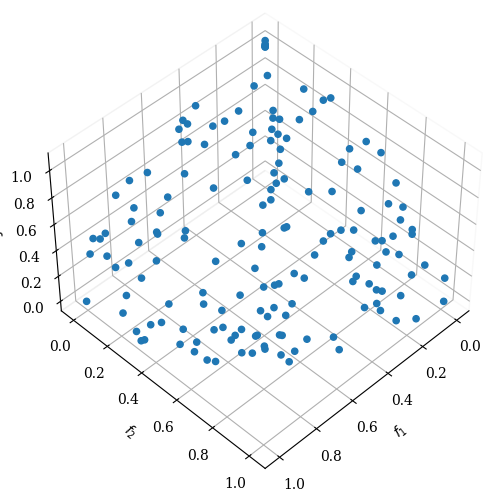

In [36]:
Scatter(angle=(45,45)).add(test()).show()

### Ótimo

Para critério de comparação, essa seria a solução ótima de acordo com o pymoo:

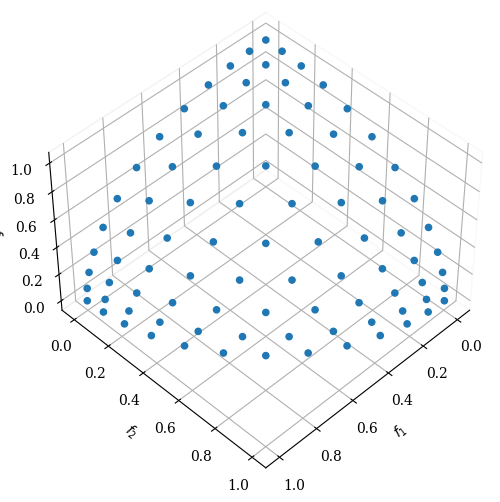

In [14]:
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)
pf = get_problem("dtlz2").pareto_front(ref_dirs)
Scatter(angle=(45,45)).add(pf).show()